In [ ]:
%matplotlib inline

import torch
import torchvision
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image
from sklearn.utils.class_weight import compute_class_weight
import os
import matplotlib.pyplot as plt

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Should be Cuda

print(device)

cuda:0


In [ ]:

#Connects to the image dataset on my personal google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# For Training
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

#For Validation and Testing
transform2 = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),# ImageNet Normalization
])

def load_image(path):
    img = Image.open(path)
    return img


# Used to store Pneumonia dataset
class CustomDataset(Dataset):
    def __init__(self, data_list, transform=None, train=True, target_size=(224,224)):
        self.data_list = data_list
        self.transform = transform
        self.train = train
        self.target_size = target_size

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        sample_path, label = self.data_list[idx]
        sample = load_image(sample_path)
        sample = transforms.functional.resize(sample, self.target_size)
        if self.transform:
            sample = self.transform(sample)

        return sample, label

['test', 'train', 'val']
['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']


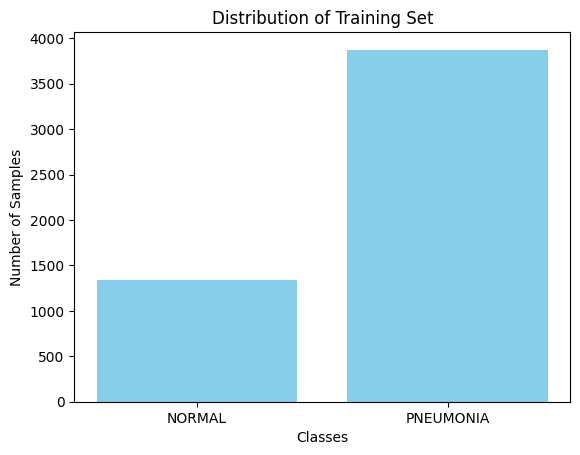

[1.9448173  0.67303226]


In [ ]:
dataset_root = '/content/drive/MyDrive/data'

sets = os.listdir(dataset_root)
sets.sort()
print(sets)


# Populates all three sets (training, validation, test)
def pop_data_list(path,data_list):
    classes = os.listdir(path)
    classes.sort()
    class_labels = {cls: i for i, cls in enumerate(classes)}
    print(classes)
    for cls in classes:
        class_path = os.path.join(path,cls)
        if os.path.isdir(class_path):
            images = os.listdir(class_path)
            for img_name in images:
                img_path = os.path.join(class_path, img_name)
                label = class_labels[cls]
                data_list.append((img_path, label))

    return data_list

# 0 = test, 1 = train, 2 = val
image_lists = [[],[],[]]
for i in range(len(sets)):
    pop_data_list(os.path.join(dataset_root,sets[i]),image_lists[i])


# Counts number of each class in the training set
training_set_distribution = {
    'NORMAL': 0,
    'PNEUMONIA': 0
}
class_labels = []
for s in image_lists[1]:
  if s[1] == 0:
    training_set_distribution['NORMAL'] += 1
  else:
    training_set_distribution['PNEUMONIA'] += 1
  class_labels.append(s[1])


# Calculates new weights for the classes using the counts
class_weights = compute_class_weight('balanced', classes=[0,1], y=class_labels)




classes = list(training_set_distribution.keys())
counts = list(training_set_distribution.values())


plt.bar(classes, counts, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Distribution of Training Set')

# Shows distribution
plt.show()

print(class_weights)
class_weights = torch.FloatTensor(class_weights).to('cuda' if torch.cuda.is_available() else 'cpu')


tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044, -

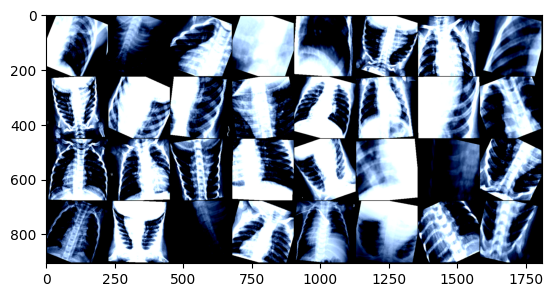

PNEUMONIA PNEUMONIA NORMAL PNEUMONIA NORMAL NORMAL NORMAL PNEUMONIA NORMAL PNEUMONIA PNEUMONIA NORMAL PNEUMONIA PNEUMONIA PNEUMONIA NORMAL NORMAL PNEUMONIA NORMAL NORMAL PNEUMONIA PNEUMONIA PNEUMONIA NORMAL PNEUMONIA NORMAL PNEUMONIA NORMAL PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA


In [ ]:
batch_size = 32
trainset = CustomDataset(image_lists[1],transform=transform, train=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = CustomDataset(image_lists[0],transform=transform2, train=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

valset = CustomDataset(image_lists[2],transform=transform2, train=False)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

classes = ('NORMAL','PNEUMONIA')
print(trainset)
print(trainloader)
print(valset)
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images)
print(labels)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

#Transfer Learning With DenseNet121
net = torchvision.models.densenet121(pretrained=True)

num_ftrs = net.classifier.in_features
net.classifier = torch.nn.Linear(num_ftrs, 2) # Two Classes (Normal, Pneumonia)
net.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 65.5MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
import torch.optim as optim

# Used the calcuated weights
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:

num_epochs = 20
min_v_loss = None
best_epoch = 0
PATH = './cifar_net.pth'
val_losses = []
train_losses = []
for epoch in range(num_epochs):

    running_loss = 0.0
    cnt = 0
    net.train()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if cnt == 0:
          print(f"Starting Epoch #{epoch+1}")
        cnt += 1

    correct = 0
    total = 0
    v_loss = 0.0
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    net.eval()
    cnt2 = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in valloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = net(inputs)
            # the class with the highest energy is what we choose as prediction
            v_loss += criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            cnt2+=1
    curr_loss = v_loss / len(valloader)

    # Find the Best Epoch of Training
    if min_v_loss == None:
        min_v_loss = curr_loss
    if min_v_loss >= curr_loss:
        min_v_loss = curr_loss
        torch.save(net.state_dict(), PATH)
        best_epoch = epoch + 1

    val_losses.append(curr_loss)
    train_losses.append(running_loss / cnt)

    # Shows Losses and Accuracy
    print(f'[Epoch #{epoch + 1}/{num_epochs}, Training loss: {running_loss / cnt:.3f}, Validation loss: {curr_loss:.3f}, Validation Accuracy: {100 * correct // total}% ]')

print(f'Finished Training, Best Epoch: {best_epoch}')

Starting Epoch #1
[Epoch #1/20, Training loss: 0.401, Validation loss: 2.080, Validation Accuracy: 62% ]
Starting Epoch #2
[Epoch #2/20, Training loss: 0.328, Validation loss: 0.886, Validation Accuracy: 56% ]
Starting Epoch #3
[Epoch #3/20, Training loss: 0.319, Validation loss: 1.274, Validation Accuracy: 50% ]
Starting Epoch #4
[Epoch #4/20, Training loss: 0.280, Validation loss: 0.657, Validation Accuracy: 68% ]
Starting Epoch #5
[Epoch #5/20, Training loss: 0.275, Validation loss: 1.446, Validation Accuracy: 50% ]
Starting Epoch #6
[Epoch #6/20, Training loss: 0.274, Validation loss: 0.420, Validation Accuracy: 81% ]
Starting Epoch #7
[Epoch #7/20, Training loss: 0.268, Validation loss: 1.291, Validation Accuracy: 56% ]
Starting Epoch #8
[Epoch #8/20, Training loss: 0.279, Validation loss: 1.011, Validation Accuracy: 50% ]
Starting Epoch #9
[Epoch #9/20, Training loss: 0.242, Validation loss: 0.463, Validation Accuracy: 87% ]
Starting Epoch #10
[Epoch #10/20, Training loss: 0.242,

In [ ]:

x_values = range(1,num_epochs+1)
print(train_losses)
v_losses= []
print(val_losses)
for v in val_losses:
  v_losses.append(v.tolist())
print(v_losses)

# Plotting the line graph
print(type(val_losses))
plt.plot(x_values, train_losses, marker='o', linestyle='-', color='skyblue', label='Training Loss')
plt.plot(x_values, v_losses, marker='o', linestyle='-', color='red', label='Validation Loss')
plt.xlabel('Epoch #')
plt.ylabel('Cross Entropy Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.xticks(range(1, num_epochs + 1))

# Show the plot
plt.show()

# Load in Best Epoch
net.load_state_dict(torch.load(PATH))



NameError: ignored

# New Section

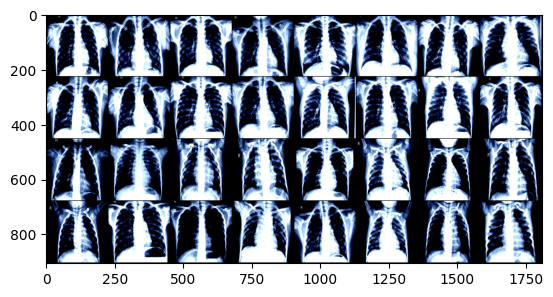

GroundTruth:  NORMAL NORMAL NORMAL NORMAL


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
net.eval()
images = images.to(device)
outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  NORMAL NORMAL NORMAL NORMAL


In [ ]:

correct = 0
total = 0
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for label, prediction in zip(labels, predicted):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

print(f'Testing Accuracy: {100 * correct // total} %')
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Testing Accuracy: 93 %
Accuracy for class: NORMAL is 91.5 %
Accuracy for class: PNEUMONIA is 95.0 %
